In [33]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
from tensorflow.keras import backend as K
mse = tf.keras.losses.MeanSquaredError()

# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_evaluation as mode_eval

import myplot

import h5py
import numpy as np
from numpy import einsum
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import time
import os
import configparser
import datetime
import wandb

# get system information
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']

# use gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[0], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


In [69]:
# data
data_file = './data/PIV4_downsampled_by8.h5'
Ntrain = 1632 # snapshots for training
Nval = 550 # sanpshots for validation
Ntest = 550

# Boolean 
LATENT_STATE = True # save latent state
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.000 #1e-05 #regulariser
drop_rate = 0.0
features_layers = [32, 64, 128]
latent_dim = 2
act_fct = 'linear'
resize_meth = 'bilinear'
filter_window= (5,5)
batch_norm = False

## training
nb_epoch = 3000
batch_size = 200
learning_rate = 0.001

Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny, Nz]

## Data

In [3]:
#============================= READ DATA FROM FILE ================================
hf = h5py.File('./data/ufluc_shuffle_1632.h5','r')
u_all = np.array(hf.get('u_all'))
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_test = np.array(hf.get('u_test'))
u_mean_all = np.array(hf.get('u_mean_all'))
u_mean_train = np.array(hf.get('u_mean_train'))
u_mean_val = np.array(hf.get('u_mean_val'))
u_mean_test = np.array(hf.get('u_mean_test'))
hf.close()

In [91]:
# POD data
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod_data = md.POD(X,method='classic')
Q_POD_data,lam_data = pod_data.get_modes
Q_mean = pod_data.Q_mean
recons_data = pod_data.reconstruct(latent_dim,shape=[2,Ny,Nz,u_train.shape[1]])
recons_data = np.transpose(recons_data,[3,1,2,0])

A_data = pod_data.get_time_coefficient
pod_modes_t = []
for i in range(latent_dim):
    Q_add = pod_data.Phi[:,[i]] @ A_data[:,[i]].T
    rebuildv = np.reshape(Q_add,[2,Ny,Nz,A_data.shape[0]])
    pod_modes_t.append(rebuildv)
pod_modes_t = np.array(pod_modes_t) # [latent_dim,velocity,Ny,Nz,time]

Calculating POD ...
User has selected classic POD
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


In [5]:
# prepare validation data
vy = u_val[0,:,:,:,0] + u_mean_val[:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = u_val[0,:,:,:,1] + u_mean_val[:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy))

pod_val = md.POD(X,method='classic')
Q_POD_val,lam_val = pod_val.get_modes
A_val = pod_val.get_time_coefficient

Calculating POD ...
User has selected classic POD
POD done.


## Set up decoder

In [70]:
encoder = Encoder(Nx,Nu,features_layers,latent_dim,filter_window,act_fct='tanh',batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)
layer_size = encoder.get_layer_shape()

In [ ]:
### single decoder

decoders = []
add_modes = []
inn = Input(shape=(latent_dim))
for i in range(latent_dim):
    decoders.append(
        Decoder(Nx=Nx,Nu=Nu,layer_size=layer_size,features_layers=features_layers,latent_dim=1,filter_window=filter_window,act_fct='tanh',batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)
        )
out = decoders[0](inn)
mdl = Model(inn,out)
print(mdl.summary())

In [71]:
# set up network
# sum(decoders) = flow
decoders = []
add_modes = []
inn = Input(shape=(latent_dim))
for i in range(latent_dim):
    decoders.append(
        Decoder(Nx=Nx,Nu=Nu,layer_size=layer_size,features_layers=features_layers,latent_dim=1,filter_window=filter_window,act_fct='tanh',batch_norm=batch_norm,drop_rate=drop_rate,lmb=lmb)
        )
    x = Lambda(lambda x,i: x[:,i:i+1],arguments={'i':i})(inn)
    x = decoders[i](x)
    add_modes.append(x)
    del x
out = Add()(add_modes)
mdl = Model(inn,out)
print(mdl.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['input_6[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['input_6[0][0]']                
                                                                                                  
 decoder_2 (Decoder)            (None, 21, 24, 2)    258752      ['lambda_2[0][0]']               
                                                                                            

In [72]:
mdl.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')

## Training decoder

In [73]:
# training control
pat = 200 # early stopping
tempfn = './temp_decoder.h5'
model_cb=ModelCheckpoint(tempfn, monitor='loss',save_best_only=True,verbose=1,save_weights_only=True)
early_cb=EarlyStopping(monitor='loss', patience=pat,verbose=1)
cb = [model_cb, early_cb]

In [74]:
# clear history
hist_train = []
hist_val = []

In [75]:
# modify input
A_train_in = A_data[:,:2]
A_val_in = A_val[:,:2]

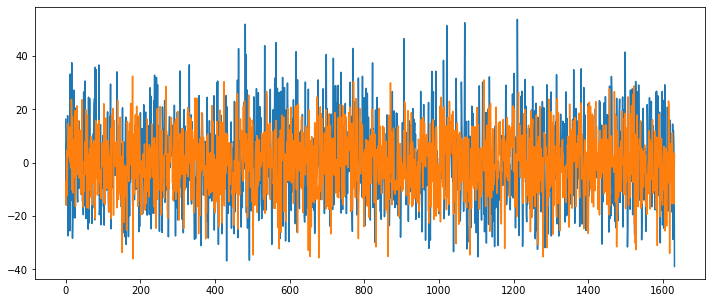

In [76]:
plt.figure(figsize=(12,5))
plt.plot(A_train_in)
plt.show()

In [77]:
hist = mdl.fit(A_train_in,u_train[0,:,:,:,:],
            epochs=nb_epoch,batch_size=batch_size,shuffle=True,
            validation_data=(A_val_in,u_val[0,:,:,:,:]),
            callbacks=cb,verbose=1)
hist_train.extend(hist.history['loss'])
hist_val.extend(hist.history['val_loss'])
mdl.load_weights(tempfn)

Epoch 1/3000
9/9 [==============================] - ETA: 0s - loss: 2.0538
Epoch 00001: loss improved from inf to 2.05378, saving model to ./temp_decoder.h5
9/9 [==============================] - 1s 58ms/step - loss: 2.0538 - val_loss: 1.6415
Epoch 2/3000
9/9 [==============================] - ETA: 0s - loss: 1.6335
Epoch 00002: loss improved from 2.05378 to 1.63352, saving model to ./temp_decoder.h5
9/9 [==============================] - 0s 28ms/step - loss: 1.6335 - val_loss: 1.5523
Epoch 3/3000
9/9 [==============================] - ETA: 0s - loss: 1.5731
Epoch 00003: loss improved from 1.63352 to 1.57314, saving model to ./temp_decoder.h5
9/9 [==============================] - 0s 28ms/step - loss: 1.5731 - val_loss: 1.5291
Epoch 4/3000
9/9 [==============================] - ETA: 0s - loss: 1.5430
Epoch 00004: loss improved from 1.57314 to 1.54304, saving model to ./temp_decoder.h5
9/9 [==============================] - 0s 29ms/step - loss: 1.5430 - val_loss: 1.5119
Epoch 5/3000
9/9

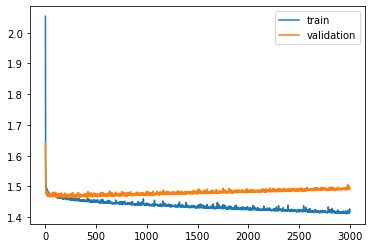

In [78]:
plt.figure()
plt.plot(hist_train,label='train')
plt.plot(hist_val,label='validation')
plt.legend()
plt.show()

In [79]:
# get results
y = mdl.predict(A_train_in)

mode_shape = []
ae_modes = []
for i in range(latent_dim):
    mode_shape.append(decoders[i].predict(np.reshape(1,(1,1))))
    ae_modes.append(decoders[i].predict(A_train_in[:,[i]]))
y_add = np.sum(ae_modes,axis=0)
print('are results calculated through two methods the same?',np.array_equal(y,y_add))

mode_shape = np.array(mode_shape)
ae_modes = np.array(ae_modes)

are results calculated through two methods the same? True


## Visualise results

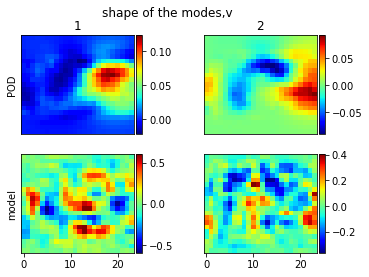

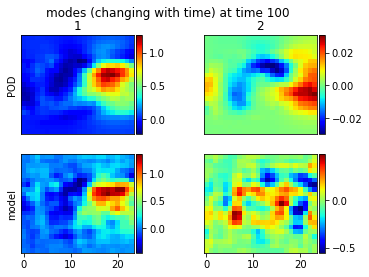

In [80]:
# visulise the weights of the decoder
fig1,ax1 = plt.subplots(2,latent_dim,sharey='all')
fig1.suptitle('shape of the modes,v')
ax1[0,0].set_ylabel('POD')
ax1[1,0].set_ylabel('model')
for i in range(latent_dim):
    pltV = np.reshape(Q_POD_data[:,i],[2*Ny,Nz])
    im1 = ax1[0,i].imshow(pltV[:Ny,:],'jet')
    ax1[0,i].set_title(str(i+1))
    ax1[0,i].set_xticks([])
    ax1[0,i].set_yticks([])
    div = make_axes_locatable(ax1[0,i])
    cax = div.append_axes('right',size='5%',pad='2%')
    plt.colorbar(im1,cax=cax)

    im2 = ax1[1,i].imshow(mode_shape[i,0,:,:,0],'jet')
    div = make_axes_locatable(ax1[1,i])
    cax = div.append_axes('right',size='5%',pad='2%')
    plt.colorbar(im2,cax=cax)

# visualise the changing modes
t = 100

fig2,ax2 = plt.subplots(2,latent_dim,sharey='all')
# fig2,ax2 = plt.subplots(2,[latent_dim],sharey='all')
fig2.suptitle(f'modes (changing with time) at time {t}')
ax2[0,0].set_ylabel('POD')
ax2[1,0].set_ylabel('model')
for i in range(latent_dim):
    pltV_t = pod_modes_t[i,0,:,:,t]
    im1 = ax2[0,i].imshow(pltV_t,'jet')
    ax2[0,i].set_title(str(i+1))
    ax2[0,i].set_xticks([])
    ax2[0,i].set_yticks([])
    div = make_axes_locatable(ax2[0,i])
    cax = div.append_axes('right',size='5%',pad='2%')
    plt.colorbar(im1,cax=cax)

    im2 = ax2[1,i].imshow(ae_modes[i,t,:,:,0],'jet')
    div = make_axes_locatable(ax2[1,i])
    cax = div.append_axes('right',size='5%',pad='2%')
    plt.colorbar(im2,cax=cax)

plt.show()

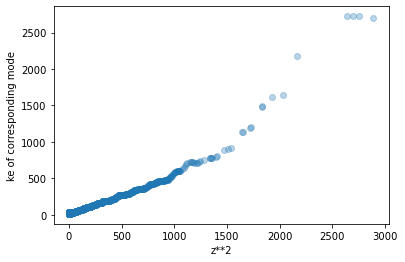

correlation coefficient 0.9565487936316703


In [81]:
ke = 0.5 * np.einsum('z t x y u -> z t', ae_modes**2)

plt.figure()
plt.scatter(A_data[:,0]**2, ke[0,:], alpha=0.3)
plt.xlabel('z**2')
plt.ylabel('ke of corresponding mode')
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(A_data[:,0]**2), ke[0,:])[0,1])

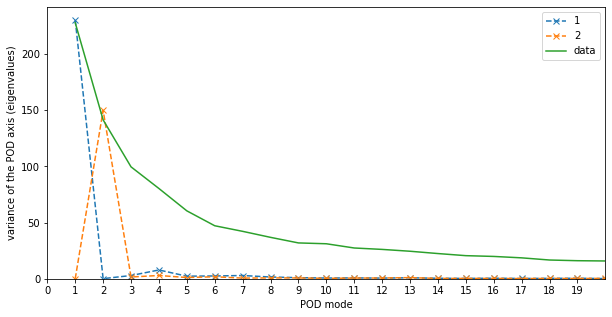

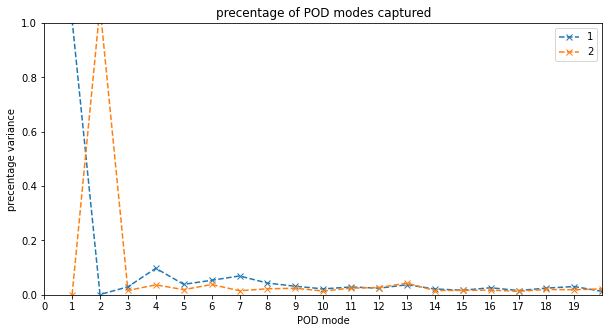

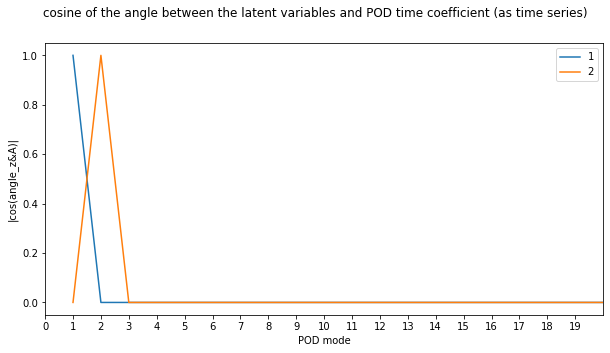

In [104]:
# reproject autoencoder modes onto data pod modes
lam_modes = mode_eval.equivalent_pca_energy(ae_modes,Q_POD_data)
lam_modes_percent = lam_modes/lam_data

x_axis = np.arange(1, Nz*Ny*Nu+1)

plt.figure(figsize=(10,5))
for i in range(latent_dim):
    plt.plot(x_axis,lam_modes[i,:],label=i+1,linestyle='--',marker='x')
plt.plot(x_axis,lam_data,label='data')
plt.xlim([0,20])
plt.xticks(range(20))
plt.ylim(bottom=0)
plt.ylabel('variance of the POD axis (eigenvalues)')
plt.xlabel('POD mode')
plt.legend()

plt.figure(figsize=(10,5))
for i in range(latent_dim):
    plt.plot(x_axis,lam_modes_percent[i,:],label=i+1,linestyle='--',marker='x')
plt.xlim([0,20])
plt.ylim([0,1])
plt.xticks(range(20))
plt.legend()
plt.xlabel('POD mode')
plt.ylabel('precentage variance')
plt.title('precentage of POD modes captured')


# Similarity between time coeffcient and latent variables
mag_A = einsum('t x -> x',A_data**2)**0.5

plt.figure(figsize=(10,5))
plt.suptitle('cosine of the angle between the latent variables and POD time coefficient (as time series)')
plt.xlabel('POD mode')
plt.ylabel('|cos(angle_z&A)|')
for i in range(latent_dim):
    mag_z = np.sum(A_data[:,i]**2)**0.5
    divisor = mag_A * mag_z
    z_dot_A = A_data[:,[i]].T @ A_data
    cos_angle = (z_dot_A / divisor).flatten()
    plt.plot(x_axis, np.abs(cos_angle),label=str(i+1))
plt.xlim([0,20])
plt.xticks(range(20))
plt.legend()


plt.show()

In [105]:
c = []
c.append(recons_data[:,:,:,0])
c.append(recons_data[:,:,:,1])
c = np.transpose(c,[1,2,3,0])

print('mse:')
print('reconstruction by POD:   ', mse(u_train[0,:,:,:,:],c).numpy())
print('reconstructed by model:  ', mse(u_train[0,:,:,:,:],y).numpy())

mse:
reconstruction by POD:    1.4777343273162842
reconstructed by model:   1.4079658
